a)

In [83]:
import pandas as pd

# crearea dataFrame-ului
data = pd.read_csv('Prices.csv')
data.head()

,Price,Speed,HardDrive,Ram,Premium
0,1499,66,540,8,yes
1,2190,33,426,8,yes
2,2745,66,1600,24,yes
3,2744,50,420,8,yes
4,1849,33,212,4,no


In [84]:
# Transformăm valorile 'yes' și 'no' în 1 și 0
data['Premium'] = data['Premium'].apply(lambda x: 1 if x == 'yes' else 0)
frecvente = data['Premium'].value_counts()
print(frecvente)

Premium
1    453
0     47
Name: count, dtype: int64


In [85]:
# Calcularea numărului de instanțe
numar_instante = data.shape[0]  # Prima dimensiune a shape este numărul de rânduri
print(f"Numărul de instanțe: {numar_instante}")

Numărul de instanțe: 500


In [86]:
# Verificam daca exista valori lipsa
print('Numarul valorilor lipsa pentru fiecare variabila:')
print(data.isnull().sum())

Numarul valorilor lipsa pentru fiecare variabila:
Price        0
Speed        0
HardDrive    0
Ram          0
Premium      0
dtype: int64


In [87]:
# Numărul de duplicate
num_duplicates = data.duplicated().sum()
print("Număr de duplicate:", num_duplicates)

Număr de duplicate: 42


In [88]:
# Eliminam duplicatele
data = data.drop_duplicates()

In [89]:
import numpy as np

x1 = data['Speed']
x2 = data['HardDrive']
y = data['Price']

# aplicam logaritmul natural asupra coloanei 'HarDrive'
x2 = np.log(x2)

In [90]:
import pymc as pm

with pm.Model() as model:
    # a priori slab informativ
    alpha = pm.Normal('alpha', mu = 0, sigma = 10)
    beta1 = pm.Normal('beta1', mu = 0, sigma = 10)
    beta2 = pm.Normal('beta2', mu = 0, sigma = 10)
    eps = pm.HalfCauchy('eps', 5)

    mu = alpha + beta1 * x1 + beta2 * x2

    # likelihood
    y_pred = pm.Normal('y_pred', mu = mu, sigma = eps, observed = y)

    idata = pm.sample(5000, tune=5000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, eps]


Output()

Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 32 seconds.


In [91]:
import arviz as az

az.summary(idata, var_names=['alpha', 'beta1', 'beta2', 'eps'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,15.893,10.057,-2.062,35.417,0.074,0.058,18447.0,13147.0,1.0
beta1,28.948,1.146,26.753,31.084,0.012,0.008,9266.0,11436.0,1.0
beta2,91.481,9.877,73.117,110.341,0.103,0.073,9156.0,11362.0,1.0
eps,711.247,27.346,660.131,762.324,0.244,0.172,12581.0,13260.0,1.0


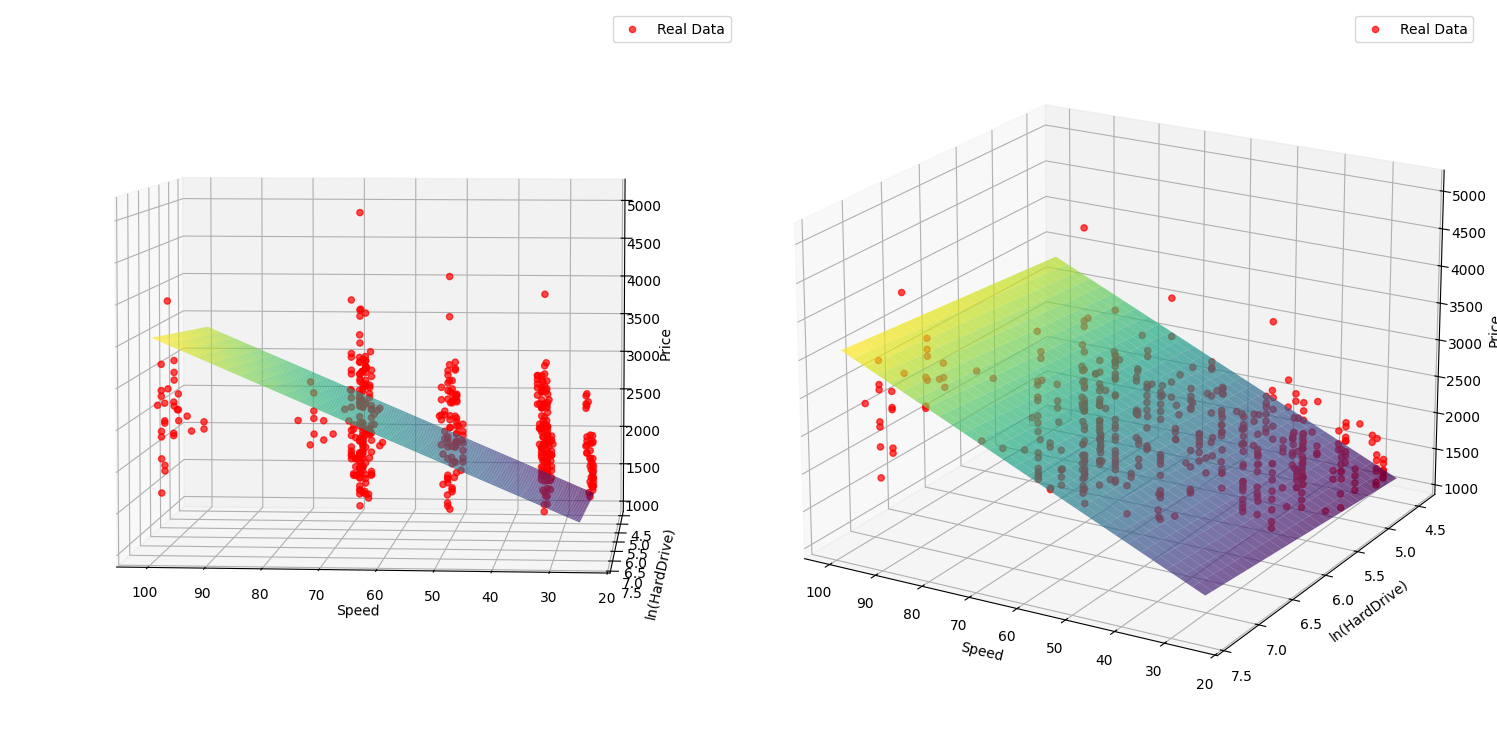

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extragem coeficienții posteriori medii
alpha_mean = idata.posterior['alpha'].mean().values
beta1_mean = idata.posterior['beta1'].mean().values
beta2_mean = idata.posterior['beta2'].mean().values

# Definim grila de valori pentru x1, x2
x1_min, x1_max = np.min(x1), np.max(x1)
x2_min, x2_max = np.min(x2), np.max(x2)

x1_range = np.linspace(x1_min, x1_max, 30)
x2_range = np.linspace(x2_min, x2_max, 30)
X1, X2 = np.meshgrid(x1_range, x2_range)

# Calculăm valorile preestimate ale y
Y_pred = alpha_mean + beta1_mean * X1 + beta2_mean * X2

fig = plt.figure(figsize=(15, 10))

# Primul plot 3D
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(X1, X2, Y_pred, cmap='viridis', alpha=0.7)
ax1.scatter(x1, x2, y, color='red', s=20, alpha=0.7, label='Real Data')
ax1.set_xlabel('Speed')
ax1.set_ylabel('ln(HardDrive)')
ax1.set_zlabel('Price')
ax1.legend()
# Setăm un unghi de vizualizare
ax1.view_init(elev=5, azim=95)

# Al doilea plot 3D, cu un unghi diferit
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(X1, X2, Y_pred, cmap='viridis', alpha=0.7)
ax2.scatter(x1, x2, y, color='red', s=20, alpha=0.7, label='Real Data')
ax2.set_xlabel('Speed')
ax2.set_ylabel('ln(HardDrive)')
ax2.set_zlabel('Price')
ax2.legend()
# Schimbăm unghiul de vizualizare pentru a vedea din altă perspectivă
ax2.view_init(elev=20, azim=120)

plt.tight_layout()
plt.show()

b)

array([<Axes: title={'center': 'beta1'}>,
       <Axes: title={'center': 'beta2'}>], dtype=object)

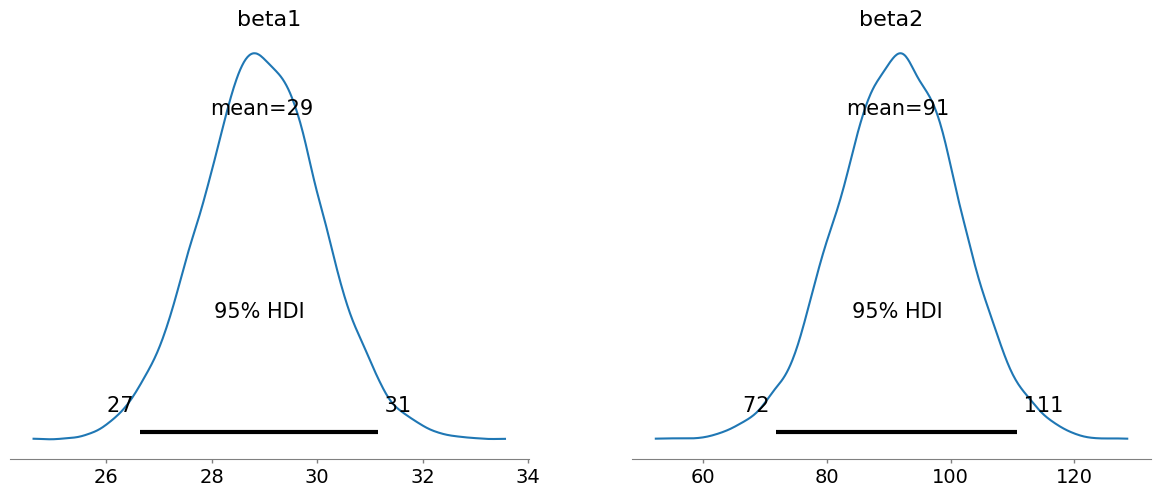

In [93]:
az.plot_posterior(
    idata, 
    var_names=["beta1", "beta2"], 
    hdi_prob=0.95
)


c)

Pe baza intervalelor HDI obținute, există o probabilitate a posteriori de 95% ca coeficienții β1 și β2 să se regăsească în intervalele indicate. Întrucât aceste intervale nu includ valoarea 0, rezultă că frecvența procesorului și dimensiunea hard disk-ului au un efect semnificativ din punct de vedere statistic și contribuie la prezicerea prețului (y). Dacă, în schimb, valorile acestor coeficienți ar fi putut fi 0, atunci cei doi factori nu ar fi avut nicio influență asupra prețului.

d)

Pretul de vanzare asteptat (90% HDI): [1485.19884898 1604.59095314]


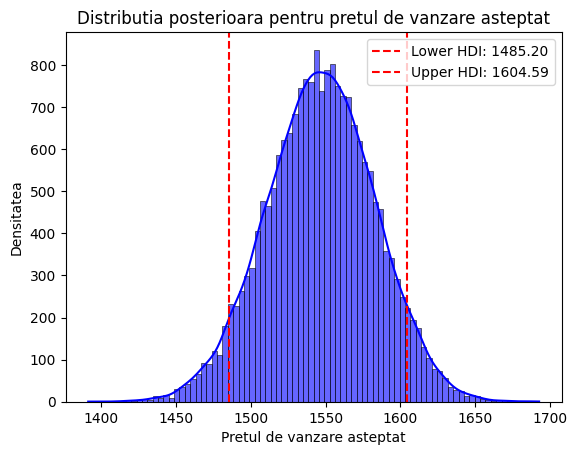

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Noile intrari
x1_new = 33
x2_new = np.log(540)

# Extragem 5000 de valori din distributia posterioara pentru (alpha, beta1, beta2)
alpha_samples = idata.posterior['alpha'].values.flatten()
beta1_samples = idata.posterior['beta1'].values.flatten()
beta2_samples = idata.posterior['beta2'].values.flatten()

mu_samples = alpha_samples + beta1_samples * x1_new + beta2_samples * x2_new

# Calculăm HDI la 90%
mu_hdi_90 = pm.hdi(mu_samples, hdi_prob=0.90)

print(f"Pretul de vanzare asteptat (90% HDI): {mu_hdi_90}")
sns.histplot(mu_samples, kde=True, color="blue", alpha=0.6)
plt.axvline(mu_hdi_90[0], color="red", linestyle="--", label=f"Lower HDI: {mu_hdi_90[0]:.2f}")
plt.axvline(mu_hdi_90[1], color="red", linestyle="--", label=f"Upper HDI: {mu_hdi_90[1]:.2f}")
plt.title("Distributia posterioara pentru pretul de vanzare asteptat")
plt.xlabel("Pretul de vanzare asteptat")
plt.ylabel("Densitatea")
plt.legend()
plt.show()

 price (90% HDI): [ 381.54865228 2740.27358928]


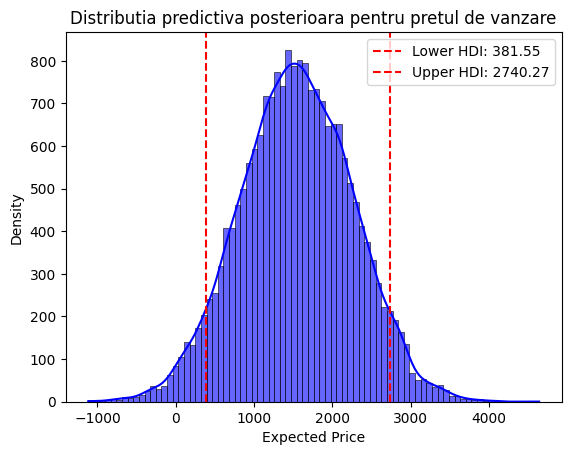

In [95]:
sigma_samples = idata.posterior['eps'].values.flatten()

# y_new ~ Normal(mu, sigma)
y_new_samples = np.random.normal(mu_samples, sigma_samples)

# Interval de predicție 90% HDI:
y_new_hdi_90 = pm.hdi(y_new_samples, hdi_prob=0.90)
print(f" price (90% HDI): {y_new_hdi_90}")
sns.histplot(y_new_samples, kde=True, color="blue", alpha=0.6)
plt.axvline(y_new_hdi_90[0], color="red", linestyle="--", label=f"Lower HDI: {y_new_hdi_90[0]:.2f}")
plt.axvline(y_new_hdi_90[1], color="red", linestyle="--", label=f"Upper HDI: {y_new_hdi_90[1]:.2f}")
plt.title("Distributia predictiva posterioara pentru pretul de vanzare")
plt.xlabel("Expected Price")
plt.ylabel("Density")
plt.legend()
plt.show()


e)

In [96]:
x3 = data['Premium']

with pm.Model() as model:
    # Priori pentru coeficienți
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta1 = pm.Normal('beta1', mu=0, sigma=10)
    beta2 = pm.Normal('beta2', mu=0, sigma=10)
    beta3 = pm.Normal('beta3', mu=0, sigma=10)  # Coeficient pentru premium
    eps = pm.HalfCauchy('eps', beta=5)

    # Media liniei de regresie
    mu = alpha + beta1 * x1 + beta2 * x2 + beta3 * x3

    # Likelihood
    y_pred = pm.Normal('y_pred', mu=mu, sigma=eps, observed=y)

    # Sampling
    idata = pm.sample(5000, tune=5000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, beta3, eps]


Output()

Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 35 seconds.


In [97]:
az.summary(idata, var_names=['alpha', 'beta1', 'beta2', 'beta3', 'eps'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,15.800,9.941,-2.561,34.875,0.067,0.053,22099.0,14318.0,1.0
beta1,28.777,1.171,26.559,30.952,0.010,0.007,12645.0,13466.0,1.0
beta2,91.432,9.898,72.149,109.360,0.088,0.062,12667.0,13090.0,1.0
beta3,11.134,10.008,-7.793,29.860,0.066,0.058,23135.0,14198.0,1.0
eps,709.605,27.476,659.004,761.136,0.221,0.157,15380.0,13934.0,1.0


Conform parametrilor estimati mai sus, valoarea asteptata a pretului este dat de ecuatia:

> $ \mu = 15.688 \;+\; 28.791 \times \text{frecvență} \;+\; 91.319 \times \ln(\text{hard disk}) \;+\; 11.126 \times \text{premium} $

Daca produsul dat este premium, atunci variabila $premium = 1$ si obtinem:
> $ \mu = 15.688 \;+\; 28.791 \times \text{frecvență} \;+\; 91.319 \times \ln(\text{hard disk}) \;+\; 11.126$

> $ \mu = 26,814 \;+\; 28.791 \times \text{frecvență} \;+\; 91.319 \times \ln(\text{hard disk})$

Altfel, premium = 0 si obtinem:
> $ \mu = 15.688 \;+\; 28.791 \times \text{frecvență} \;+\; 91.319 \times \ln(\text{hard disk})$


Astfel, un computer premium, având aceeași frecvență a procesorului și dimensiune a hard disk-ului, ar fi estimat la un preț cu aproximativ 11.126 dolari mai ridicat decât unul non-premium. Totuși, având în vedere că această diferență nu este foarte mare, putem concluziona că statutul de „premium” nu influențează semnificativ prețul.


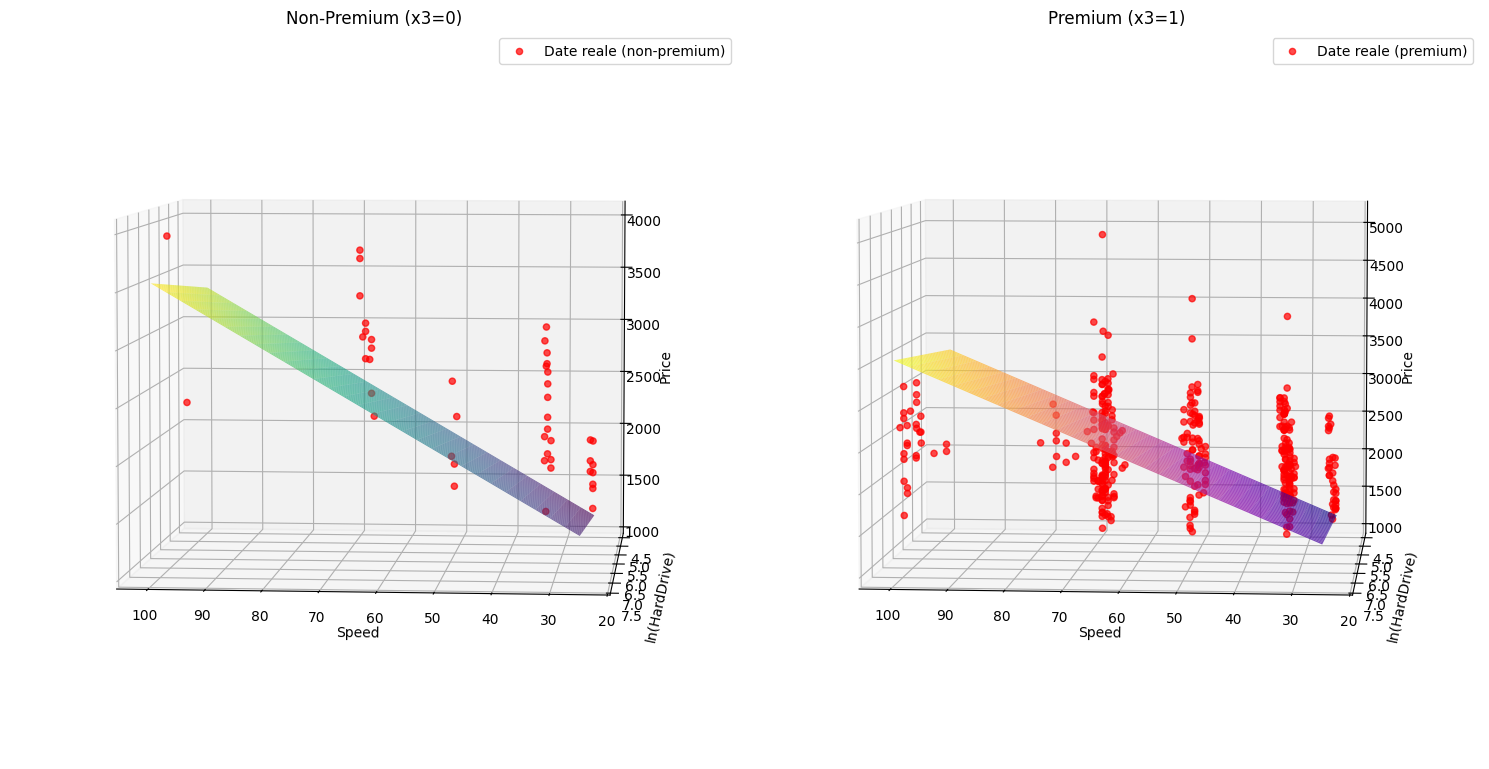

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extragem coeficienții posteriori medii
alpha_mean = idata.posterior['alpha'].mean().values
beta1_mean = idata.posterior['beta1'].mean().values
beta2_mean = idata.posterior['beta2'].mean().values
beta3_mean = idata.posterior['beta3'].mean().values

# Stabilim domeniul pentru x1 și x2 pe baza datelor reale
x1_min, x1_max = np.min(x1), np.max(x1)
x2_min, x2_max = np.min(x2), np.max(x2)

x1_range = np.linspace(x1_min, x1_max, 30)
x2_range = np.linspace(x2_min, x2_max, 30)
X1, X2 = np.meshgrid(x1_range, x2_range)

# Calculăm suprafața de regresie pentru non-premium (x3=0)
Y_non_premium = alpha_mean + beta1_mean*X1 + beta2_mean*X2 + beta3_mean*0

# Calculăm suprafața de regresie pentru premium (x3=1)
Y_premium = alpha_mean + beta1_mean*X1 + beta2_mean*X2 + beta3_mean*1

fig = plt.figure(figsize=(15, 10))

# Grafic pentru non-premium
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(X1, X2, Y_non_premium, cmap='viridis', alpha=0.7)
# Puncte reale pentru non-premium
non_prem_mask = (x3 == 0)
ax1.scatter(x1[non_prem_mask], x2[non_prem_mask], y[non_prem_mask], color='red', s=20, alpha=0.7, label='Date reale (non-premium)')
ax1.set_xlabel('Speed')
ax1.set_ylabel('ln(HardDrive)')
ax1.set_zlabel('Price')
ax1.set_title('Non-Premium (x3=0)')
ax1.legend()
ax1.view_init(elev=5, azim=95)

# Grafic pentru premium
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(X1, X2, Y_premium, cmap='plasma', alpha=0.7)
# Puncte reale pentru premium
prem_mask = (x3 == 1)
ax2.scatter(x1[prem_mask], x2[prem_mask], y[prem_mask], color='red', s=20, alpha=0.7, label='Date reale (premium)')
ax2.set_xlabel('Speed')
ax2.set_ylabel('ln(HardDrive)')
ax2.set_zlabel('Price')
ax2.set_title('Premium (x3=1)')
ax2.legend()
ax2.view_init(elev=5, azim=95)

plt.tight_layout()
plt.show()

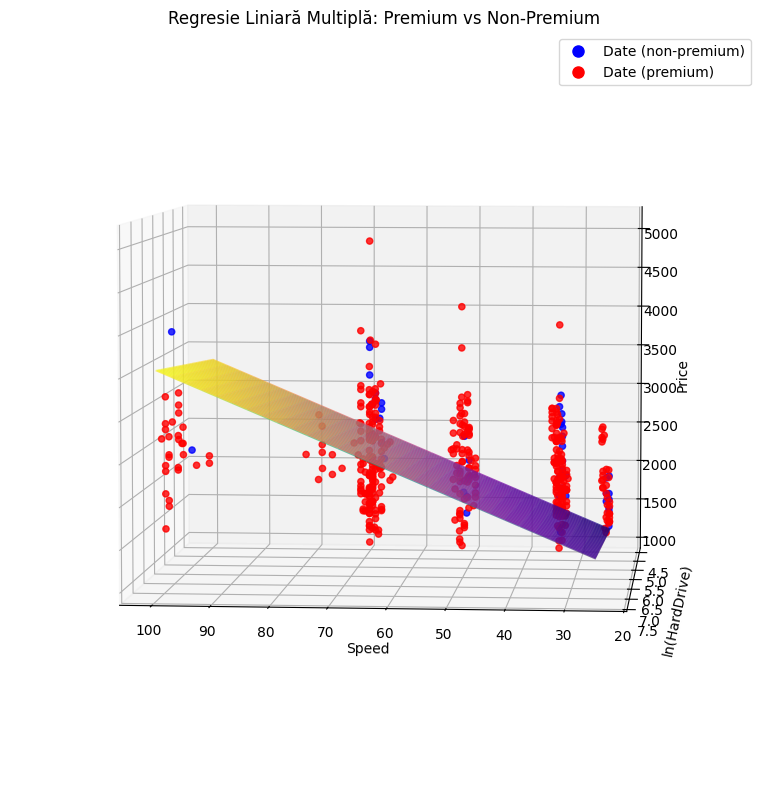

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

# Extragem coeficienții posteriori medii
alpha_mean = idata.posterior['alpha'].mean().values
beta1_mean = idata.posterior['beta1'].mean().values
beta2_mean = idata.posterior['beta2'].mean().values
beta3_mean = idata.posterior['beta3'].mean().values

# Stabilim domeniul pentru x1 și x2 pe baza datelor reale
x1_min, x1_max = np.min(x1), np.max(x1)
x2_min, x2_max = np.min(x2), np.max(x2)

x1_range = np.linspace(x1_min, x1_max, 30)
x2_range = np.linspace(x2_min, x2_max, 30)
X1, X2 = np.meshgrid(x1_range, x2_range)

# Suprafață non-premium (x3=0)
Y_non_premium = alpha_mean + beta1_mean*X1 + beta2_mean*X2 + beta3_mean*0
# Suprafață premium (x3=1)
Y_premium = alpha_mean + beta1_mean*X1 + beta2_mean*X2 + beta3_mean*1

# Mască pentru date
non_prem_mask = (x3 == 0)
prem_mask = (x3 == 1)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Suprafețele de regresie
surf1 = ax.plot_surface(X1, X2, Y_non_premium, cmap='viridis', alpha=0.7)  # Non-Premium
surf2 = ax.plot_surface(X1, X2, Y_premium, cmap='plasma', alpha=0.7)       # Premium

# Punctele de date
ax.scatter(x1[non_prem_mask], x2[non_prem_mask], y[non_prem_mask], 
           color='blue', s=20, alpha=0.8, label='Date (non-premium)')
ax.scatter(x1[prem_mask], x2[prem_mask], y[prem_mask], 
           color='red', s=20, alpha=0.8, label='Date (premium)')

ax.set_xlabel('Speed')
ax.set_ylabel('ln(HardDrive)')
ax.set_zlabel('Price')
ax.set_title('Regresie Liniară Multiplă: Premium vs Non-Premium')

# Creăm manual legendă, deoarece suprafețele nu au etichete directe
custom_lines = [
    Line2D([0], [0], marker='o', color='blue', label='Date (non-premium)', markersize=8, linestyle='None'),
    Line2D([0], [0], marker='o', color='red', label='Date (premium)', markersize=8, linestyle='None'),
]

ax.legend(handles=custom_lines, loc='best')

ax.view_init(elev=5, azim=95)
plt.tight_layout()
plt.show()